# Imported Modules

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision.models import resnet50, ResNet50_Weights
import torchvision.transforms as T

import os
import math as m
from PIL import Image as I
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix as cm

from ray import train, tune
from ray.tune.schedulers import ASHAScheduler
from ray.train import Checkpoint
from ray.tune.search.optuna import OptunaSearch

# Model Initialization, Layer Replacement, Device Location

In [75]:
x = resnet50(weights=ResNet50_Weights.DEFAULT)

for param in x.parameters():
    param.requires_grad = False

x.fc = nn.Linear(2048, 12)
nn.init.kaiming_uniform_(x.fc.weight, nonlinearity='relu')
x.fc.requires_grad = True

if torch.cuda.is_available():
    device = "cuda"
elif getattr(torch, 'has_mps', False):
    device = "mps"
else:
    device = "cpu"

x = x.to(device)

/var/folders/yj/n5srfxb951l5x6hcn4jcx3000000gn/T/ipykernel_51918/4026304798.py:12: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  elif getattr(torch, 'has_mps', False):


# Unnormalization Class

In [40]:
class Unnormalize(object):
    def __init__(self, mean=None, std=None):
        self.mean = mean
        self.std = std
    
    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

# Data Loading Function

In [41]:
data_labels = {}
unnorm = Unnormalize()

def load_images():
    #Bunch of arrays for storing and moving data
    aux_img = []
    aux_labels = []
    train_imgs = []
    train_labels = []
    test_imgs = []
    test_labels = []
    val_imgs = []
    val_labels = []
    idx = 0

    crop = T.CenterCrop((128, 128))

    #Cycle through various folders for images
    for folder in range(len(sorted(os.listdir('./DeepLearningProject/Data')))):
        if sorted(os.listdir('./DeepLearningProject/Data'))[folder] == '.DS_Store':
            continue
        else:
            aux_img = os.listdir('./DeepLearningProject/Data/'+sorted(os.listdir('./DeepLearningProject/Data'))[folder])

            for i in range(len(aux_img)):
                #Remove .DS_Store file from data
                if aux_img[i] == '.DS_Store':
                    aux_img.pop(i)
                    break
            
            #Resize Image and Convert Channels
            for i in range(len(aux_img)):
                try:
                    with I.open('./DeepLearningProject/Data/'+sorted(os.listdir('./DeepLearningProject/Data'))[folder]+'/'+aux_img[i]) as img:
                        img = crop(img)

                        if img.mode != 'RGB':
                            img = img.convert('RGB')

                        img = np.array(img)
                        aux_img[i] = img
                except Exception as e:
                    print(f"{i}")
            aux_labels = []

            #Generate Labels
            for i in range(len(aux_img)):
                aux_labels.append(idx)
            idx += 1

            #Divide Data and Labels into Training, Testing, and Validation Sets
            train_imgs += aux_img[:int(m.ceil(len(aux_img)*0.6))]
            aux_img = aux_img[int(m.ceil(len(aux_img)*0.6)):]
            val_imgs += aux_img[:int(m.ceil(len(aux_img)*0.75))]
            aux_img = aux_img[int(m.ceil(len(aux_img)*0.75)):]
            test_imgs += aux_img

            train_labels += aux_labels[:int(m.ceil(len(aux_labels)*0.6))]
            aux_labels = aux_labels[int(m.ceil(len(aux_labels)*0.6)):]
            val_labels += aux_labels[:int(m.ceil(len(aux_labels)*0.75))]
            aux_labels = aux_labels[int(m.ceil(len(aux_labels)*0.75)):]
            test_labels += aux_labels
        data_labels[folder-1] = sorted(os.listdir('./DeepLearningProject/Data'))[folder]

    #Data Normalization RGB -> [0, 1]
    aux_img = []
    aux_img = train_imgs + test_imgs + val_imgs
    mu = np.mean(aux_img, axis=(0, 1, 2))
    sigma = np.std(aux_img, axis=(0, 1, 2))
    unnorm.mean = mu
    unnorm.std = sigma

    normalize = T.Compose([
        T.Normalize(mu, sigma)
    ])

    #Conversion to tensors and recast data
    train_imgs, test_imgs, val_imgs = torch.tensor(train_imgs).to(torch.float32), torch.tensor(test_imgs).to(torch.float32), torch.tensor(val_imgs).to(torch.float32)
    train_labels, test_labels, val_labels = torch.tensor(train_labels), torch.tensor(test_labels), torch.tensor(val_labels)

    #Shuffle Images Sets
    train_imgs, train_labels = shuffle_imgs(train_imgs, train_labels)
    test_imgs, test_labels = shuffle_imgs(test_imgs, test_labels)
    val_imgs, val_labels = shuffle_imgs(val_imgs, val_labels)

    #Normalize and Reorder Data for Processing
    train_imgs = normalize(train_imgs.permute(0, 3, 1, 2))
    test_imgs = normalize(test_imgs.permute(0, 3, 1, 2))
    val_imgs = normalize(val_imgs.permute(0, 3, 1, 2))

    train_set, test_set, val_set = TensorDataset(train_imgs, train_labels), TensorDataset(test_imgs, test_labels), TensorDataset(val_imgs, val_labels)

    trainloader, testloader, valloader = DataLoader(dataset=train_set, shuffle=True, batch_size=128), DataLoader(dataset=test_set, shuffle=True, batch_size=64), DataLoader(dataset=val_set, shuffle=True, batch_size=64)

    return trainloader, testloader, valloader

#Shuffle Images according to Random Noise Generation
def shuffle_imgs(imgs, labels):
   B = imgs.size(0)
   shuffle = torch.randperm(B)
   return imgs[shuffle], labels[shuffle]

In [42]:
trainloader, testloader, valloader = load_images()
print(data_labels)

{0: 'apples', 1: 'coconuts', 2: 'grapes', 3: 'guavas', 4: 'lemons', 5: 'limes', 6: 'mango', 7: 'oranges', 8: 'peaches', 9: 'starfruit', 10: 'strawberries', 11: 'watermelons'}


# Train, Test, and Finetuning Functions

In [76]:
#Training Method with Adam Optimizer
def trainfunc(model, traindata, valdata, epochs):
    optimizer = optim.Adam(model.parameters(), lr=0.006349288161821683, eps=6.5131448417080975e-09)
    #optimizer = optim.SGD(model.parameters(), lr=0.006349288161821683)
    lr_optim = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
    loss_list = []
    loss_list_aux = []
    validation_loss = []
    validation_loss_aux = []

    for i in range(epochs):
        for imgs, labels in traindata:
            imgs = imgs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            logits = model(imgs)
            loss = F.cross_entropy(logits, labels)
            loss_list_aux.append(loss.item())

            loss.backward()
            optimizer.step()
        loss_list.append(torch.mean(torch.tensor(loss_list_aux)))
        lr_optim.step()

        with torch.no_grad():
            div = 0
            tot = 0
            for imgs, labels in valdata:
                imgs = imgs.to(device)
                labels = labels.to(device)
                val_logits = model(imgs)
                validation_loss_aux.append(F.cross_entropy(val_logits, labels).item())
                val_logits = nn.Softmax()(val_logits)
                pred = torch.argmax(val_logits, axis=1)
                tot += (pred == labels).float().sum().item()
                div += imgs.shape[0]
            validation_loss.append(torch.mean(torch.tensor(validation_loss_aux)))
            print("Validation Accuracy: ", tot/div*100, "%")

    return model, loss_list, validation_loss

#Finetune Function
def finetune(model, data, valdata, epochs):
    model.fc.requires_grad = False
    model.avgpool.requires_grad = True
    model.layer4.requires_grad = True
    model.layer3.requires_grad = True
    model.layer2.requires_grad = True
    model.layer1.requires_grad = True
    model.maxpool.requires_grad = True
    model.conv1.requires_grad = True

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    lr_sched = optim.lr_scheduler.StepLR(optimizer, step_size=2)
    loss_list = []
    loss_list_aux = []

    for i in range(epochs):
        for imgs, labels in data:
            imgs = imgs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            logits = model(imgs)
            loss = F.cross_entropy(logits, labels)
            loss_list_aux.append(loss.item())

            loss.backward()
            optimizer.step()
        
        loss_list.append(torch.mean(torch.tensor(loss_list_aux)))
        
        div = 0
        tot = 0
        for imgs, labels in valdata:
            imgs = imgs.to(device)
            labels = labels.to(device)
            val_logits = model(imgs)
            val_logits = nn.Softmax()(val_logits)
            pred = torch.argmax(val_logits, axis=1)
            tot += (pred == labels).float().sum().item()
            div += imgs.shape[0]
        print("Validation Accuracy: ", tot/div*100, "%")
        lr_sched.step()
    return model, loss_list

def test(model, data):
    div = 0
    total = 0

    for imgs, labels in data:
        imgs = imgs.to(device)
        labels = labels.to(device)
        logits = model(imgs)
        logits = nn.Softmax()(logits)
        pred = torch.argmax(logits, axis=1)
        div += imgs.shape[0]
        total += (pred == labels).float().sum().item()
    print("Accuracy: ", total/div*100, "%")

# Confusion Matrix Function

In [44]:
def confusion_matrix(model, data):
    total_pred = []
    total_labels = []

    for imgs, labels in data:
        imgs = imgs.to(device)
        labels = labels.to(device)

        logits = model(imgs)
        logits = nn.Softmax()(logits)
        pred = torch.argmax(logits, axis=1)

        total_pred += list(pred.to('cpu'))
        total_labels += list(labels.to('cpu'))

    con_mat = cm(total_labels, total_pred)
    labels = [data_labels[i] for i in range(len(con_mat))]
    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(con_mat, annot=True, cmap="inferno", xticklabels=labels, yticklabels=labels)
    plt.title(f'ResNet50 Accuracy')
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.show()
    plt.clf()

# Hyperparameter Tuning Functions

In [79]:
def hfinetunetrain(model, data, optimizer, lr_sched):
    for imgs, labels in data:
        imgs, labels = imgs.to(device), labels.to(device)

        pred = model(imgs)
        optimizer.zero_grad()
        loss = F.cross_entropy(pred, labels)
        loss.backward()
        optimizer.step()
        lr_sched.step()
    torch.mps.empty_cache()

def hfinetunetest(model, data):
    model.eval()
    correct = 0
    total = 0

    for imgs, labels in data:
        imgs, labels = imgs.to(device), labels.to(device)

        outputs = model(imgs)
        
        pred = torch.argmax(outputs, axis=1)

        total += imgs.shape[0]
        correct += (pred == labels).float().sum().item()
    torch.mps.empty_cache()
    return correct/total

def objective(config):
    train_loader, test_loader, val_loader = load_images()

    model = resnet50(weights=ResNet50_Weights.DEFAULT).to(device)
    for param in x.parameters():
        param.requires_grad = False

    model.fc = nn.Sequential(nn.Linear(2048, config["l1"]),
                                       nn.ReLU(),
                                       nn.Linear(config["l1"], config["l2"]),
                                       nn.ReLU(),
                                       nn.Linear(config["l2"], 12)
                                       ).to(device)
    nn.init.kaiming_uniform_(x.fc.weight, nonlinearity='relu')
    x.fc.requires_grad = True

    optimizer = optim.Adam(model.parameters(), lr=config["lr"], eps=config["eps"])
    lr_sched = optim.lr_scheduler.StepLR(optimizer, step_size=config["lr_sched_step"])

    for epoch in range(10):
        hfinetunetrain(model, train_loader, optimizer, lr_sched)
        acc = hfinetunetest(model, val_loader)
        
        checkpoint = None
        if (epoch+1)%5 == 0:
            torch.save(model.state_dict(),
                       "/./DeepLearningProject/TuningCheckpoints/model.pth")
            checkpoint = Checkpoint.from_directory("./DeepLearningProject/TuningCheckpoints")
        train.report({"mean_accuracy": acc}, checkpoint=checkpoint)

        if device == "cuda":
            torch.cuda.empty_cache()
        elif device == "mps":
            torch.mps.empty_cache()

# Model Benchmark with Replaced Layer

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Accuracy:  8.108108108108109 %


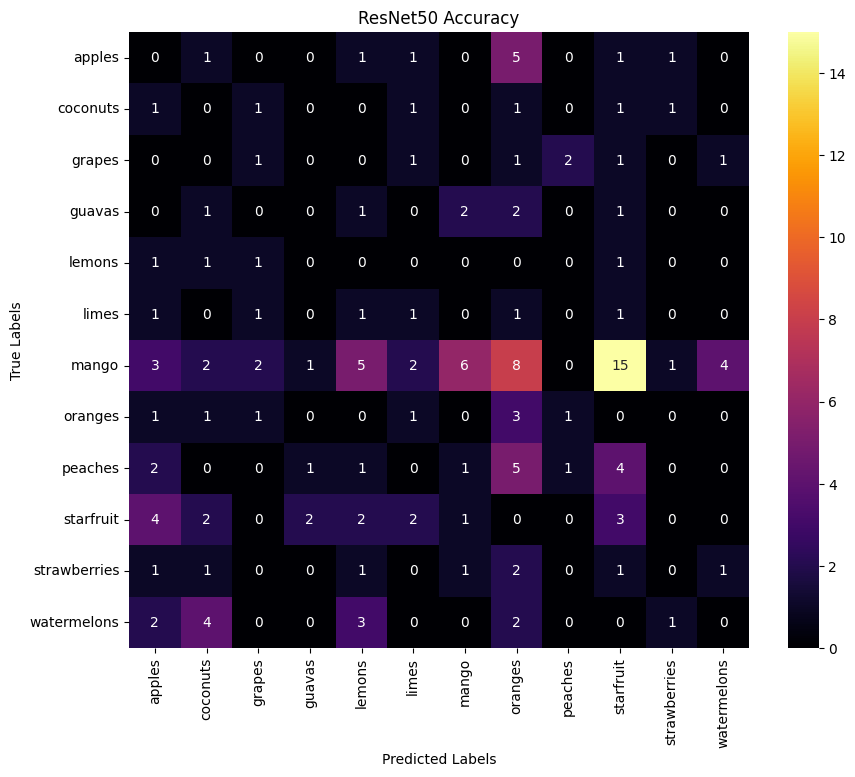

<Figure size 640x480 with 0 Axes>

In [46]:
test(x, testloader)

confusion_matrix(x, testloader)

# Training ResNet50 FC Layer

Validation Accuracy:  68.76355748373102 %
Validation Accuracy:  77.00650759219089 %
Validation Accuracy:  79.17570498915401 %
Validation Accuracy:  80.6941431670282 %
Validation Accuracy:  80.26030368763557 %
Validation Accuracy:  82.86334056399133 %
Validation Accuracy:  80.4772234273319 %
Validation Accuracy:  80.26030368763557 %
Validation Accuracy:  81.56182212581345 %
Validation Accuracy:  81.56182212581345 %
Validation Accuracy:  81.34490238611714 %
Validation Accuracy:  81.12798264642083 %
Validation Accuracy:  81.77874186550976 %
Validation Accuracy:  81.34490238611714 %
Validation Accuracy:  80.91106290672451 %
Validation Accuracy:  81.56182212581345 %
Validation Accuracy:  81.56182212581345 %
Validation Accuracy:  82.86334056399133 %
Validation Accuracy:  83.51409978308027 %
Validation Accuracy:  82.4295010845987 %
Validation Accuracy:  80.91106290672451 %
Validation Accuracy:  80.91106290672451 %
Validation Accuracy:  85.03253796095444 %
Validation Accuracy:  81.995661605206

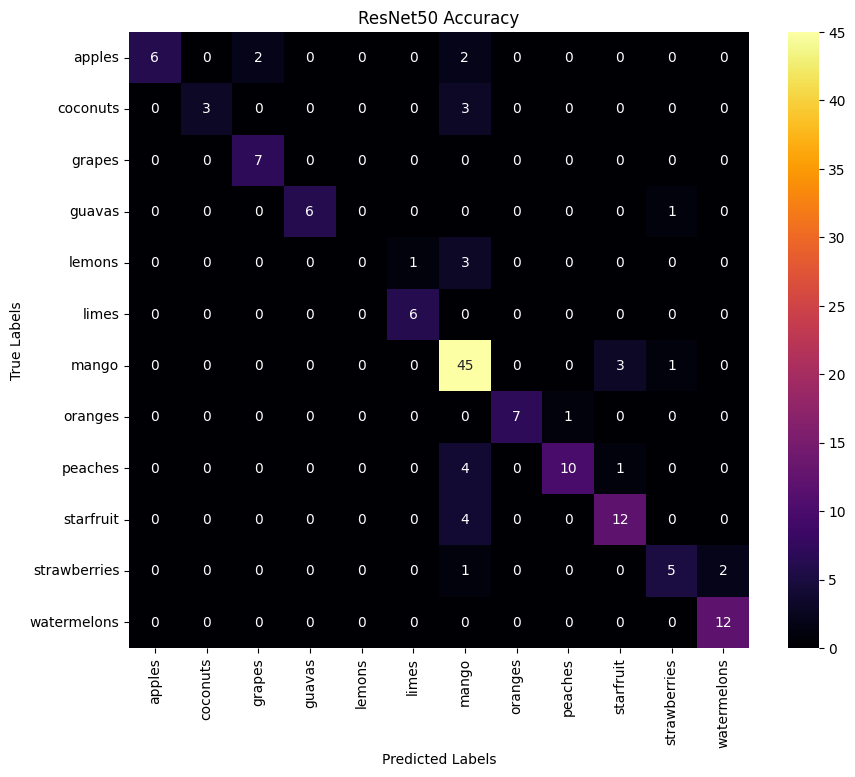

<Figure size 640x480 with 0 Axes>

In [77]:
x, loss_list, val_loss = trainfunc(x, trainloader, valloader, 200)
test(x, testloader)

confusion_matrix(x, testloader)

# Finetuning Pre-trained Layers

In [78]:
x, loss_list_val = finetune(x, trainloader, valloader, 200)
test(x, testloader)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Validation Accuracy:  83.51409978308027 %
Validation Accuracy:  83.73101952277658 %
Validation Accuracy:  83.94793926247289 %
Validation Accuracy:  83.51409978308027 %
Validation Accuracy:  82.21258134490239 %
Validation Accuracy:  82.646420824295 %
Validation Accuracy:  81.99566160520607 %
Validation Accuracy:  85.03253796095444 %
Validation Accuracy:  83.08026030368764 %
Validation Accuracy:  83.51409978308027 %
Validation Accuracy:  83.29718004338395 %
Validation Accuracy:  84.1648590021692 %
Validation Accuracy:  84.59869848156181 %
Validation Accuracy:  84.3817787418655 %
Validation Accuracy:  85.46637744034707 %
Validation Accuracy:  82.21258134490239 %
Validation Accuracy:  83.51409978308027 %
Validation Accuracy:  83.73101952277658 %
Validation Accuracy:  83.94793926247289 %
Validation Accuracy:  83.73101952277658 %
Validation Accuracy:  84.81561822125813 %
Validation Accuracy:  82.646420824295 %
Validation Accuracy:  83.94793926247289 %
Validation Accuracy:  83.08026030368764 

# Hyperparameter Tuning

In [80]:
search_space = {"lr": tune.loguniform(1e-4, 1e-1), "eps": tune.loguniform(1e-10, 1e-6), "l1": tune.randint(50, 2049), "l2": tune.randint(12, 101), "lr_sched_step": tune.randint(1, 21)}
tuner = tune.Tuner(objective, tune_config=tune.TuneConfig(metric="mean_accuracy", mode="max", search_alg=OptunaSearch(), num_samples=2), param_space=search_space)

results = tuner.fit()
print("Best Config is: ", results.get_best_result().config)

(raylet) Warning: The actor ImplicitFunc is very large (90 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.


(objective pid=73208) /var/folders/yj/n5srfxb951l5x6hcn4jcx3000000gn/T/ipykernel_51918/3592750841.py:78: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
(objective pid=73226) /var/folders/yj/n5srfxb951l5x6hcn4jcx3000000gn/T/ipykernel_51918/3592750841.py:78: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
(objective pid=73208) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/thomassigler/ray_results/objective_2024-04-21_23-51-49/objective_a86a3129_1_eps=0.0000,l1=902,l

Best Config is:  {'lr': 0.00036340514543842494, 'eps': 6.322198209737259e-10, 'l1': 902, 'l2': 50, 'lr_sched_step': 7}


# Plotting Graphs

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


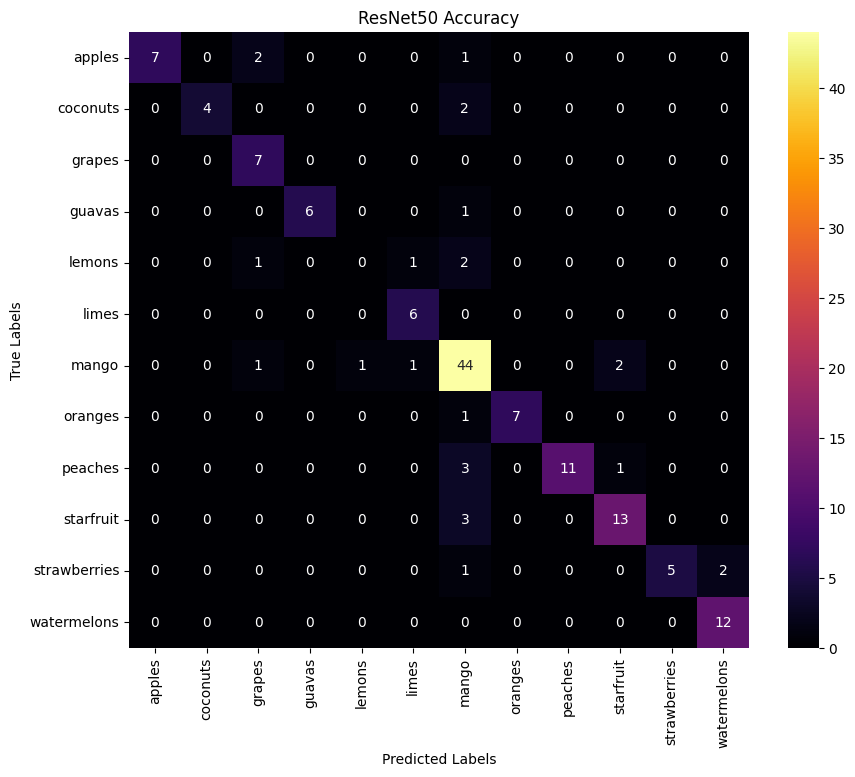

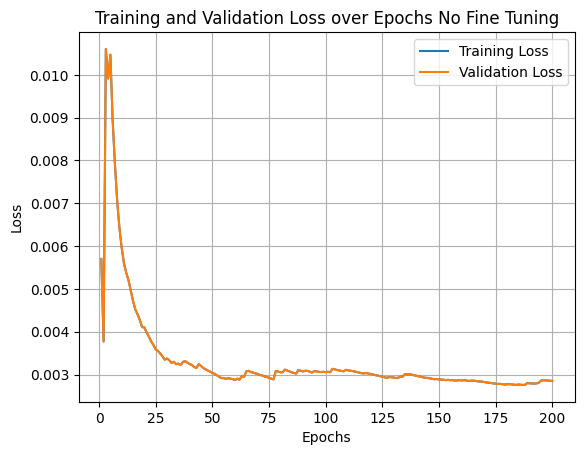

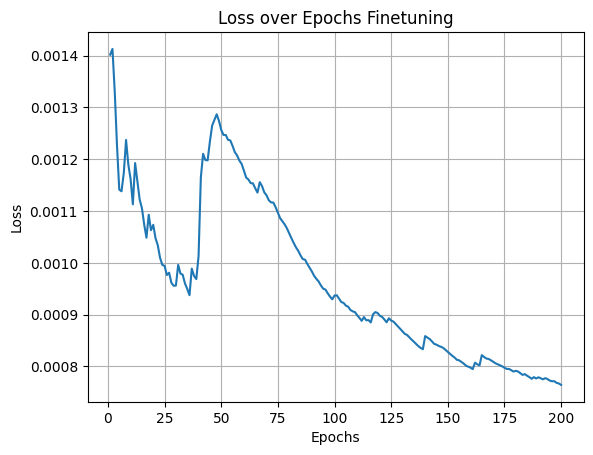

In [58]:
confusion_matrix(x, testloader)

plt.plot(np.linspace(1, len(loss_list), len(loss_list)), loss_list, label='Training Loss')
plt.plot(np.linspace(1, len(val_loss), len(loss_list)), loss_list, label='Validation Loss')
plt.title('Training and Validation Loss over Epochs No Fine Tuning')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()
plt.clf()

plt.plot(np.linspace(1, len(loss_list_val), len(loss_list_val)), loss_list_val)
plt.title('Loss over Epochs Finetuning')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()